Note: The following extra libraries are installed for the following purposes
* **Sci-py**: Use of the scipy.metrics.entropy function for computation of negentropy metric.
* **jqm_cvi**: Computation of the Dunn Index metrics

In [4]:
%pip install pandas seaborn scikit-learn scipy

In [5]:
%pip install git+https://github.com/jqmviegas/jqm_cvi.git

  Cloning https://github.com/jqmviegas/jqm_cvi.git to /tmp/pip-req-build-xgkz0tat
  Running command git clone --filter=blob:none --quiet https://github.com/jqmviegas/jqm_cvi.git /tmp/pip-req-build-xgkz0tat
  Resolved https://github.com/jqmviegas/jqm_cvi.git to commit 9e1137d4f4df70c1287011e1a544b0c3fe36af36
  Preparing metadata (setup.py) ... done
  Created wheel for jqmcvi: filename=jqmcvi-1.0-cp310-cp310-linux_x86_64.whl size=422028 sha256=087108bc4a4ea039faaf71a7282366f58ac70ec16ce939666386ad4c0b2675d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-hs6puavq/wheels/be/41/d1/f021173ed979d287d94299b802a9bee0d4d60cfa1c563a997f
Successfully built jqmcvi


In [8]:
import numpy as np

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, pairwise_distances
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from jqmcvi.base import dunn

from scipy.stats import entropy
from scipy.special import comb

# 8x8 Handwritten Digits Visualization : Continued

## a. Normalize the X data using Standard Scaler

In [9]:
digits = load_digits()
X = digits.data
y = digits.target

In [10]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

## Project the data into 2 dimensions

We apply 6 techniques for dimensionality reduction onto a 2D plane. The projections of each techique are plotted onto separate graphs and the points are colored based on their labels.

In [11]:
def apply_reduction(method, **kwargs):
  model = method(**kwargs)
  X_reduced = model.fit_transform(X_normalized)
  return X_reduced

# Applying each technique
lle = apply_reduction(LocallyLinearEmbedding, n_neighbors=200, n_components=2, random_state=0)
tsne = apply_reduction(TSNE, n_components=2, perplexity=50, random_state=0)
isomap = apply_reduction(Isomap, n_neighbors=200, n_components=2)
laplacian = apply_reduction(SpectralEmbedding, n_neighbors=200, n_components=2)
kernel_pca = apply_reduction(KernelPCA, kernel='rbf', gamma=0.01, n_components=2)
pca = apply_reduction(PCA, n_components=2)

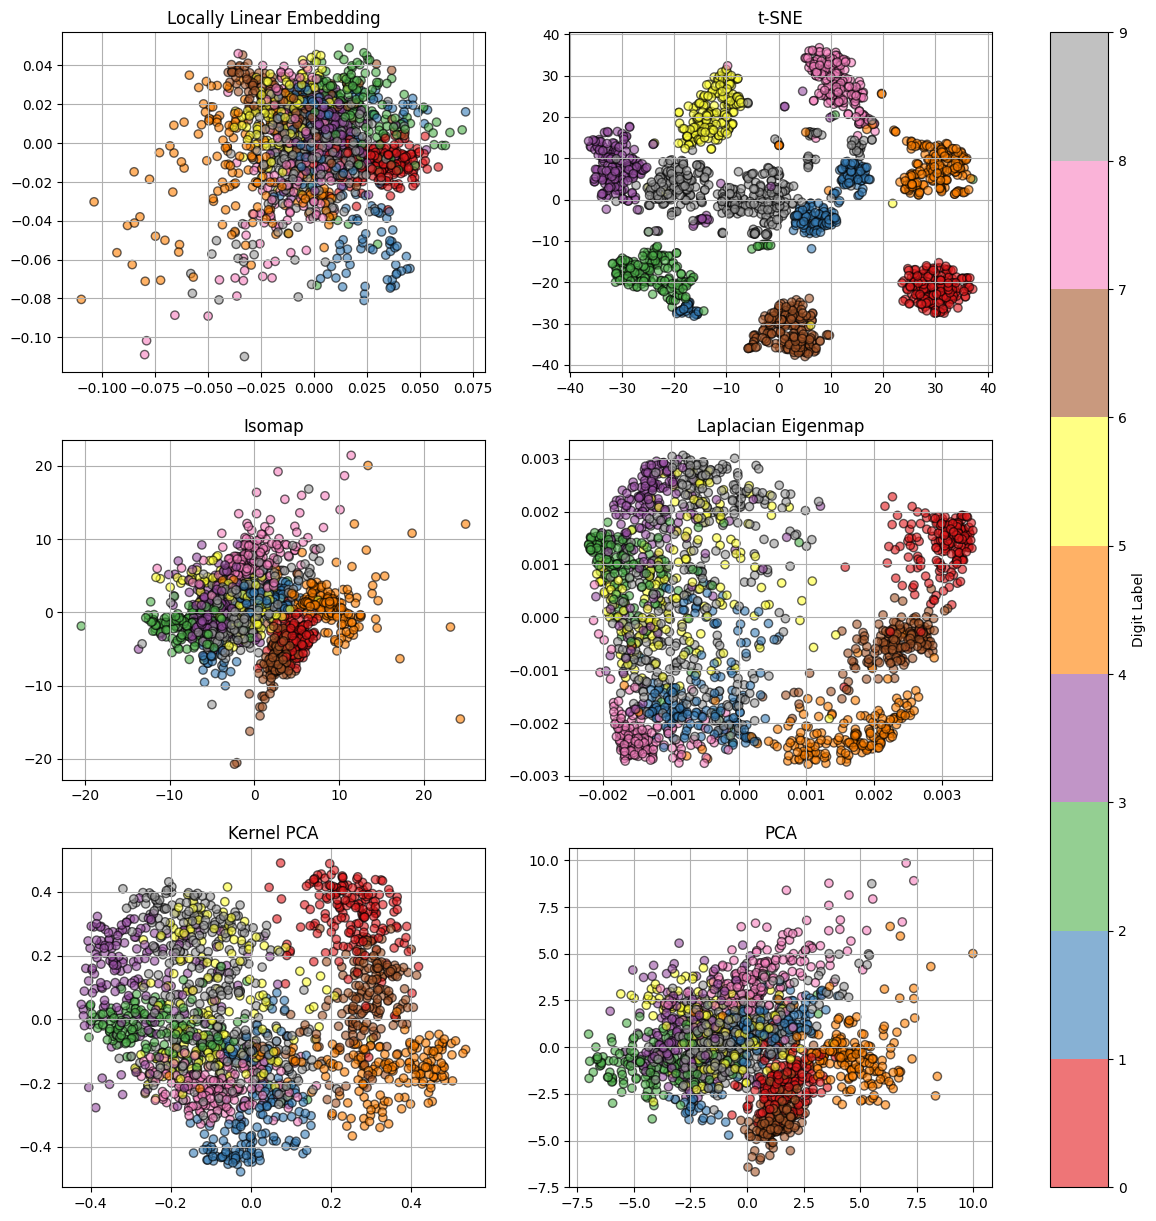

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
techniques = [lle, tsne, isomap, laplacian, kernel_pca, pca]
titles = ['Locally Linear Embedding', 't-SNE', 'Isomap', 'Laplacian Eigenmap', 'Kernel PCA', 'PCA']
metric_scores = {}

for ax, data, title in zip(axs.ravel(), techniques, titles):
  scatter = ax.scatter(data[:, 0], data[:, 1], c=y, cmap='Set1', edgecolor='k', alpha=0.6)
  ax.set_title(title)
  ax.grid(True)

  # metrics computations
  silhouette = silhouette_score(data, y)
  davies_bouldin = davies_bouldin_score(data, y)
  calinski_harabasz = calinski_harabasz_score(data, y)
  # adjusted_rand = adjusted_rand_score(y, y)
  # normalized_mutual_info = normalized_mutual_info_score(y, y)

  metric_scores[title] = {
      'Silhouette Score': silhouette,
      'Davies-Bouldin Score': davies_bouldin,
      'Calinski-Harabasz Score': calinski_harabasz,
  }

fig.colorbar(scatter, ax=axs.ravel().tolist(), orientation='vertical', label='Digit Label')
plt.show()

In [14]:
for title, scores in metric_scores.items():
  print(f'\n{title}:')
  for score_name, score_value in scores.items():
    print(f'{score_name}: {score_value}')


Locally Linear Embedding:
Silhouette Score: -0.09516935097944242
Davies-Bouldin Score: 5.325203641797647
Calinski-Harabasz Score: 134.13469301749475

t-SNE:
Silhouette Score: 0.48672837018966675
Davies-Bouldin Score: 0.9962742309462211
Calinski-Harabasz Score: 1546.4928629139113

Isomap:
Silhouette Score: 0.06988410611442517
Davies-Bouldin Score: 3.6739121839837425
Calinski-Harabasz Score: 408.0206910475094

Laplacian Eigenmap:
Silhouette Score: 0.18634596404151102
Davies-Bouldin Score: 1.7018929993195546
Calinski-Harabasz Score: 833.5267161648962

Kernel PCA:
Silhouette Score: 0.0838025172505033
Davies-Bouldin Score: 2.118274977268919
Calinski-Harabasz Score: 550.2431262748804

PCA:
Silhouette Score: 0.054742989168844736
Davies-Bouldin Score: 6.6302787089974515
Calinski-Harabasz Score: 377.96157281839953


In [23]:
# Ranking
print("Note: these scores were normalized with the range of the values across the respective metrics used.")
for method, metrics in metric_scores.items():
  silhouette_range = max(metric_scores[key]['Silhouette Score'] for key in metric_scores) - min(metric_scores[key]['Silhouette Score'] for key in metric_scores)
  db_range = max(metric_scores[key]['Davies-Bouldin Score'] for key in metric_scores) - min(metric_scores[key]['Davies-Bouldin Score'] for key in metric_scores)
  calinski_range = max(metric_scores[key]['Calinski-Harabasz Score'] for key in metric_scores) - min(metric_scores[key]['Calinski-Harabasz Score'] for key in metric_scores)

  silhouette_normalized = (metrics['Silhouette Score'] - min(metric_scores[key]['Silhouette Score'] for key in metric_scores)) / silhouette_range
  db_normalized = 1 - (metrics['Davies-Bouldin Score'] - min(metric_scores[key]['Davies-Bouldin Score'] for key in metric_scores)) / db_range
  calinski_normalized = (metrics['Calinski-Harabasz Score'] - min(metric_scores[key]['Calinski-Harabasz Score'] for key in metric_scores)) / calinski_range

  combined_score = (silhouette_normalized + db_normalized + calinski_normalized) / 3
  metric_scores[method]['Combined Score'] = combined_score


ranked_methods = sorted(metric_scores.items(), key=lambda x: x[1]['Combined Score'], reverse=True)
for rank, (method, metrics) in enumerate(ranked_methods, start=1):
  print(f'Rank {rank}: {method} (combined score {metrics["Combined Score"]})')

Note: these scores were normalized with the range of the values across the respective metrics used.
Rank 1: t-SNE (combined score 1.0)
Rank 2: Laplacian Eigenmap (combined score 0.617913326490315)
Rank 3: Kernel PCA (combined score 0.46767915731139675)
Rank 4: Isomap (combined score 0.3341013970393662)
Rank 5: PCA (combined score 0.14342158317250234)
Rank 6: Locally Linear Embedding (combined score 0.0772141776057671)


It can be seen in the scatter plots that t-SNE produced the most distinct separation of clusters out of the 6 methods. All other methods resulted in significant overlap between the different clusters. We proceeded to validate that understanding by using the Silhouette, Davies-Bouldin, and Calinski-Harabasz scores to check out the real metrics. We saw that t-SNE had the highest normalized aggregate score, followed by the Laplacian Eigenmap (Spectral Embedding) and Kernel PCA. Locally Linear Embedding performed the worse out of the six techniques.



## Problem b. Classification with(out) Dimensionality Reduction


We make a pipeline using Standard Scaler, Kernel PCA with sigmoid kernel, and SVC as the classifier. We also make a second pipeline without the Kernel PCA and compare the test accuracy and F1-Score. Note that outside of the Kernel PCA function, both pipelines share the same training/testing data and seed values to ensure that any improvements are due to the presence or absence of the Kernel PCA in the pipeline.

###a. Pipeline with PCA

In [ ]:
seed = 0
seed_svc = 0

print(f"Seed used for train-test split: {seed}")# np.random.randint((2**31)-1)}")
print(f"Seed used for svc: {seed_svc}")# np.random.randint((2**31)-1)}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

#Method 1: Kernel PCA used
pipe_pca = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('kernel_pca', KernelPCA(kernel='sigmoid',n_components=40)),
        ('classifier', SVC(random_state=seed_svc))
    ]
)

pipe_pca.fit(X_train, y_train.ravel())
print(f"Accuracy of pipeline with PCA: {accuracy_score(pipe_pca.predict(X_test),y_test)}")
print(f"F1 Score of pipeline with PCA: {f1_score(pipe_pca.predict(X_test),y_test,average=None)}")


Seed used for train-test split: 0
Seed used for svc: 0
Accuracy of pipeline with PCA: 0.9981481481481481
F1 Score of pipeline with PCA: [1.         1.         1.         1.         0.99065421 1.
 1.         1.         1.         0.99082569]
Accuracy of pipeline with PCA: 0.9814814814814815
F1 Score of pipeline with PCA: [1.         0.98181818 0.99047619 0.98148148 0.93693694 1.
 0.97196262 0.99082569 0.97142857 0.99065421]


###b. Pipeline without PCA

In [ ]:
# Method 2: No dimensionality reduction
pipe_nopca = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('classifier', SVC(random_state=seed_svc))
])
pipe_nopca.fit(X_train,y_train.ravel())
print(f"Accuracy of pipeline without PCA: {accuracy_score(pipe_nopca.predict(X_test), y_test)}")
print(f"F1 Score of pipeline without PCA: {f1_score(pipe_nopca.predict(X_test),y_test,average=None)}")


As demonstrated, the inclusion of kernel PCA in the pipeline resulted in a more accurate classifier as well as a higher F1-Score.

# Comparison of separabiilty of points by different methods

The t-SNE method appeared to be the best at separating the different points into their respective classes.

References:
* https://www.youtube.com/watch?v=P7sxhm6AYjo
* https://www.dropbox.com/scl/fo/3sjixwhdcdgrv5b0iisth/h?dl=0&e=1&preview=Mar+13+-+Linear+Dim+Reduce.mp4&rlkey=d2gsyfotom06erx0jfemcgdw0
* https://www.dropbox.com/scl/fo/3sjixwhdcdgrv5b0iisth/h?dl=0&e=1&preview=Mar+20+-+Nonlinear+Dim+Reduce.mp4&rlkey=d2gsyfotom06erx0jfemcgdw0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

pipeline_kpca_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA(n_components=40, kernel='sigmoid')),
    ('svc', SVC())
])

pipeline_kpca_svc.fit(X_train, y_train)

y_pred = pipeline_kpca_svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

accuracy, f1


(0.9981481481481481, 0.9981479893680871)

In [ ]:
data = load_digits()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

pipeline_svc.fit(X_train, y_train)

y_pred_svc = pipeline_svc.predict(X_test)

accuracy_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

accuracy_svc, f1_svc

(0.9814814814814815, 0.9816138804681078)